# Imports

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import random
import cv2
from sklearn.model_selection import train_test_split

np.random.seed(0)

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Importing the data

In [12]:


map_characters = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 
                10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 
                19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                'Z':25}


order_list=('A',  'B',  'C', 'D', 'E',  'F', 'G', 'H',  'I',  'J', 
                'K',  'L',  'M',  'N',  'O',  'P',  'Q',  'R',  'S', 
                'T',  'U',  'V',  'W',  'X',  'Y',  'Z')




lb=LabelBinarizer()
hotEncodedLabels=lb.fit_transform(order_list)




train_dir="asl_alphabet_train26"

def load_data():
    """
    Loads data and preprocess. Returns train and test data along with labels.
    """
    images = []
    labels = []
    size = 64,64
    print("LOADING DATA FROM : ",end = "")
    for folder in os.listdir(train_dir):
        print(folder, end = ' | ')
        for image in os.listdir(train_dir + "/" + folder):
                temp_img = cv2.imread(train_dir + '/' + folder + '/' + image, 0) # greyscale
                temp_img = cv2.resize(temp_img, size)
                temp_img = temp_img.flatten()
                images.append(temp_img)
                labels.append(hotEncodedLabels[labels_dict[folder]])
            
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    
    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.3, random_state=42)
    X_test, X_validation, Y_test, Y_validation = train_test_split(X_test, Y_test, test_size = 0.8,random_state=42)
    
    
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_validation),'images for validation','validation data shape =',X_validation.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)

    
    return X_train, X_test, Y_train, Y_test, X_validation, Y_validation

def confussion_matrix(cf_matrix):
    plt.figure(figsize=(10,10))
    sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Greens')

In [13]:
# with tf.device('/CPU:0'):
X_train, X_test, Y_train, Y_test, X_validation, Y_validation= load_data()


print(len(X_train))
print(len(X_validation))
print(len(X_test))

LOADING DATA FROM : A | B | C | D | E | F | G | H | I | J | K | L | M | N | O | P | Q | R | S | T | U | V | W | X | Y | Z | 
Loaded 54600 images for training, Train data shape = (54600, 4096)
Loaded 18720 images for validation validation data shape = (18720, 4096)
Loaded 4680 images for testing Test data shape = (4680, 4096)
54600
18720
4680


# Creating the neural network

In [15]:

(hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size) = (1040, 520, 260, 260,130)
x = tf.placeholder(tf.float32, [None, 4096])
y_ = tf.placeholder(tf.float32, [None, 26])

W1 = tf.Variable(tf.truncated_normal([4096, hidden1_size], stddev=0.1))
b1 = tf.Variable(tf.constant(0.1, shape=[hidden1_size]))
z1 = tf.nn.relu(tf.matmul(x,W1)+b1)

W2 = tf.Variable(tf.truncated_normal([hidden1_size, hidden2_size], stddev=0.1))
b2 = tf.Variable(tf.constant(0.1, shape=[hidden2_size]))
z2 = tf.nn.relu(tf.matmul(z1,W2)+b2)

W3 = tf.Variable(tf.truncated_normal([hidden2_size, hidden3_size], stddev=0.1))
b3 = tf.Variable(tf.constant(0.1, shape=[hidden3_size]))
z3 = tf.nn.relu(tf.matmul(z2,W3)+b3)

W4 = tf.Variable(tf.truncated_normal([hidden3_size, hidden4_size], stddev=0.1))
b4 = tf.Variable(tf.constant(0.1, shape=[hidden4_size]))
z4 = tf.nn.relu(tf.matmul(z3,W4)+b4)

W5 = tf.Variable(tf.truncated_normal([hidden4_size, hidden5_size], stddev=0.1))
b5 = tf.Variable(tf.constant(0.1, shape=[hidden5_size]))
z5 = tf.nn.relu(tf.matmul(z4,W5)+b5)

W6 = tf.Variable(tf.truncated_normal([hidden5_size, 26], stddev=0.1))
b6 = tf.Variable(tf.constant(0.1, shape=[26]))


pred = tf.nn.softmax(tf.matmul(z5, W6)+b6)
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(pred), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)


data_x=np.array(X_train)
data_y=np.array(Y_train)  
data_arr_x=[data_x[0::5],data_x[1::5],data_x[2::5],data_x[3::5],data_x[4::5]]
data_arr_y=[data_y[0::5],data_y[1::5],data_y[2::5],data_y[3::5],data_y[4::5]]


sess1 = tf.Session()
sess1.run(tf.global_variables_initializer())
saver = tf.train.Saver()

correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print("start")
acc=0
best_epoch=0
for i in range (17000):
    sess1.run(train_step, feed_dict={x: X_train, y_: Y_train})
    if i%500==0:
    # print(i, sess1.run(accuracy, feed_dict={x: X_validation, y_: Y_validation}))
        acc1=sess1.run(accuracy, feed_dict={x: X_validation, y_: Y_validation})
        if acc1>acc:
            best_epoch=i
            saver.save(sess1, "26class_5layers")
        acc=max(acc,acc1)
        print("epoch number", i,"  accuracy is : ",acc1," best accuracy seen is ", acc, "at epoch ", best_epoch)


        


start
epoch number 0   accuracy is :  0.036858976  best accuracy seen is  0.036858976 at epoch  0
epoch number 500   accuracy is :  0.18888889  best accuracy seen is  0.18888889 at epoch  500
epoch number 1000   accuracy is :  0.2701389  best accuracy seen is  0.2701389 at epoch  1000
epoch number 1500   accuracy is :  0.32767093  best accuracy seen is  0.32767093 at epoch  1500
epoch number 2000   accuracy is :  0.377297  best accuracy seen is  0.377297 at epoch  2000
epoch number 2500   accuracy is :  0.41463676  best accuracy seen is  0.41463676 at epoch  2500
epoch number 3000   accuracy is :  0.44839743  best accuracy seen is  0.44839743 at epoch  3000
epoch number 3500   accuracy is :  0.47943377  best accuracy seen is  0.47943377 at epoch  3500
epoch number 4000   accuracy is :  0.4905449  best accuracy seen is  0.4905449 at epoch  4000
epoch number 4500   accuracy is :  0.50753206  best accuracy seen is  0.50753206 at epoch  4500
epoch number 5000   accuracy is :  0.5362179  be

0.77035254


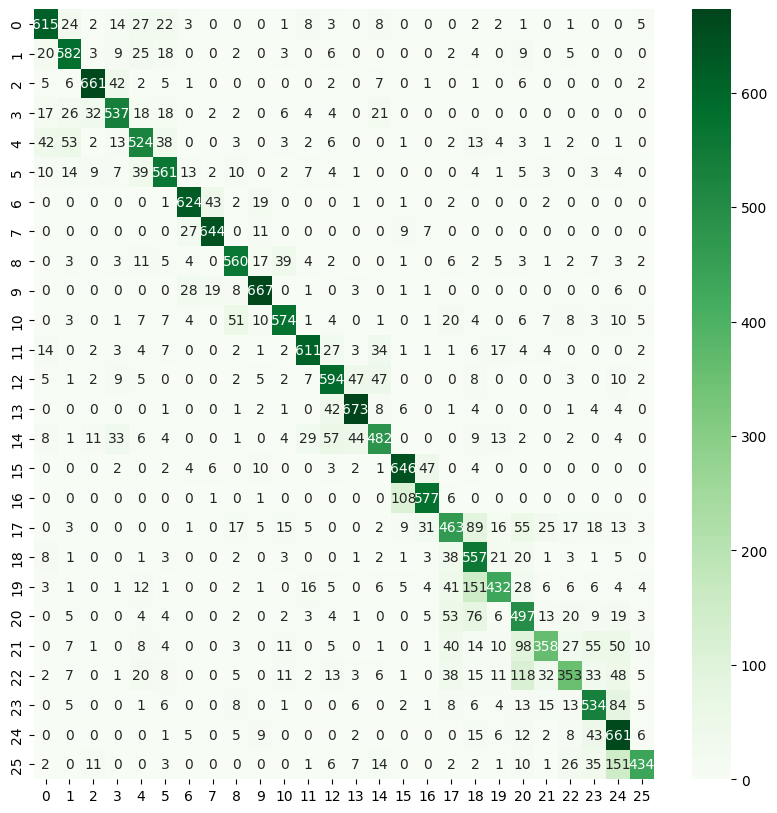

In [17]:
# validation

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# function to make pretty confusion matrix
def confussion_matrix(cf_matrix):
    plt.figure(figsize=(10,10))
    sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Greens')
    plt.show()

# make a tensor with the y validation 
y_vald=[]
for i in Y_validation:
    y_vald.append(i.tolist())
y_vald_t=tf.convert_to_tensor(
    y_vald, dtype=None, dtype_hint=None, name=None
)


# get the prediction foe x validation

mypred=sess1.run(pred,feed_dict={x: X_validation, y_: Y_validation})


# check accuracy
correct_prediction1 = tf.equal(tf.argmax(mypred,1), tf.argmax(y_vald_t,1))
accuracy1 = tf.reduce_mean(tf.cast(correct_prediction1, tf.float32))
print(sess1.run(accuracy1))


# take mypred change to a list then to a tensor
mypred_l=[]
for i in mypred:
    mypred_l.append(i.tolist())

mypred_t=tf.convert_to_tensor(
    mypred_l, dtype=None, dtype_hint=None, name=None
)


# create a list with the pred class
pred_confussion_matrix=[]
for i in sess1.run(mypred_t):
    pred_confussion_matrix.append( np.argmax(i))

# create a list with the actual class
Y_validation_confussion_matrix=[]
for i in sess1.run(y_vald_t):
    Y_validation_confussion_matrix.append( np.argmax(i))

# create the cunfusion matrix
confussion_matrix(confusion_matrix(Y_validation_confussion_matrix,pred_confussion_matrix))

In [18]:
saver = tf.train.Saver()
saver.save(sess1, "26class_5layers")

'26class_5layers'

# Testing the model on the test data

0.77991456


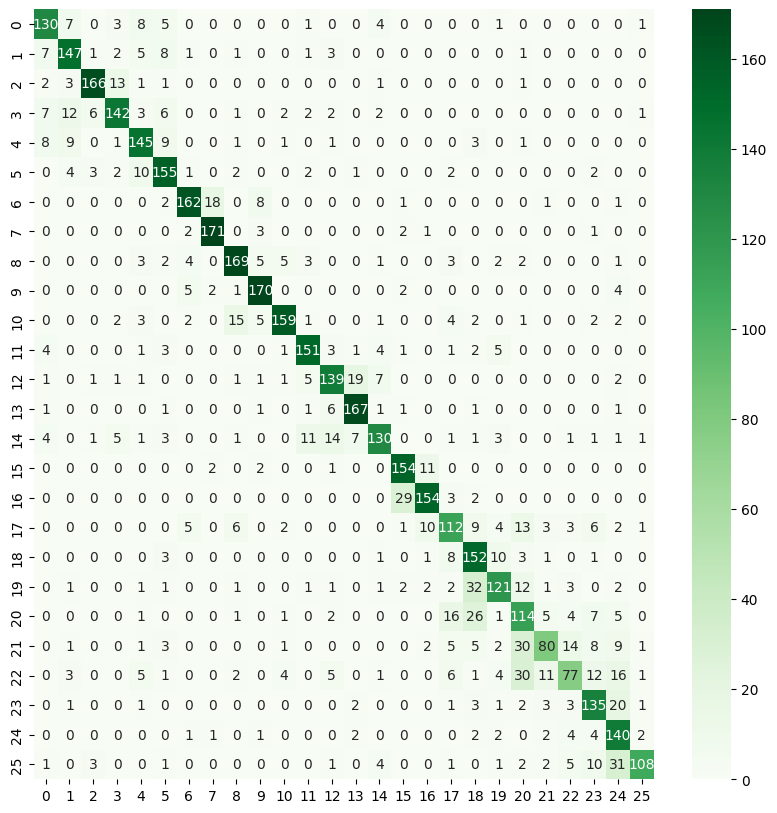

In [66]:
# make a tensor with the y test 
y_test_list=[]
for i in Y_test:
    y_test_list.append(i.tolist())
y_test_tensor=tf.convert_to_tensor(
    y_test_list, dtype=None, dtype_hint=None, name=None
)



# get the prediction for x test
mypredtest=sess1.run(pred,feed_dict={x: X_test, y_: Y_test})



# check accuracy
prediction_test = tf.equal(tf.argmax(mypredtest,1), tf.argmax(y_test_tensor,1))
accuracytest = tf.reduce_mean(tf.cast(prediction_test, tf.float32))
print(sess1.run(accuracytest))


# take mypred change to a list then to a tensor
mypredtest_list=[]
for i in mypredtest:
    mypredtest_list.append(i.tolist())

mypred_test_tensor=tf.convert_to_tensor(
    mypredtest_list, dtype=None, dtype_hint=None, name=None
)


# create a list with the pred class
pred_confussion_matrix_test=[]
for i in sess1.run(mypred_test_tensor):
    pred_confussion_matrix_test.append( np.argmax(i))

# create a list with the actual class
Y_test_confussion_matrix=[]
for i in sess1.run(y_test_tensor):
    Y_test_confussion_matrix.append( np.argmax(i))


confussion_matrix(confusion_matrix(Y_test_confussion_matrix,pred_confussion_matrix_test))

 # final accuracy is 77.99% 